# Autoencoder

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd
from datetime import datetime
# from sklearn.model_selection import GridSearchCV
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline


In [2]:
# 2. 數據預處理
input_path = '../dataSets'
train_data = pd.read_csv(os.path.join(input_path, "training.csv"))


In [3]:
# 分割出驗證集
train_data = train_data.drop(columns=["lettr"])

VALIDATE_SIZE = 0.3
RANDOM_SEED = 42
X_train, X_valid = train_test_split(train_data, test_size=VALIDATE_SIZE, random_state=RANDOM_SEED)

print(f"""Shape of the datasets:
    training (rows, cols) = {X_train.shape}
    validate (rows, cols) = {X_valid.shape}""")

Shape of the datasets:
    training (rows, cols) = (2940, 16)
    validate (rows, cols) = (1260, 16)


Normalising & Standardising

In [4]:

# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

pipeline.fit(X_train)

x_train = pipeline.transform(X_train)
x_valid = pipeline.transform(X_valid)



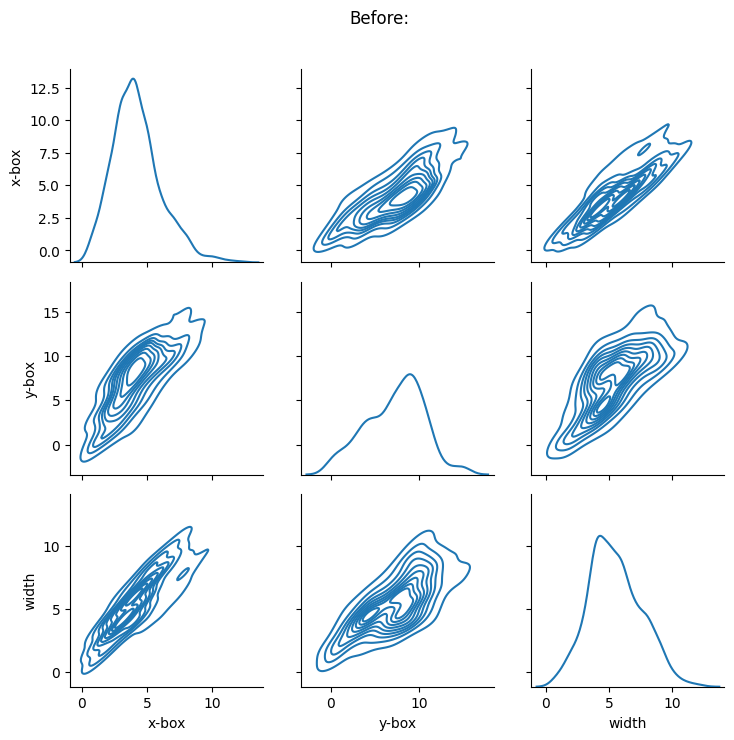

In [5]:
# visualisations
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.PairGrid(X_train.iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Before:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot)



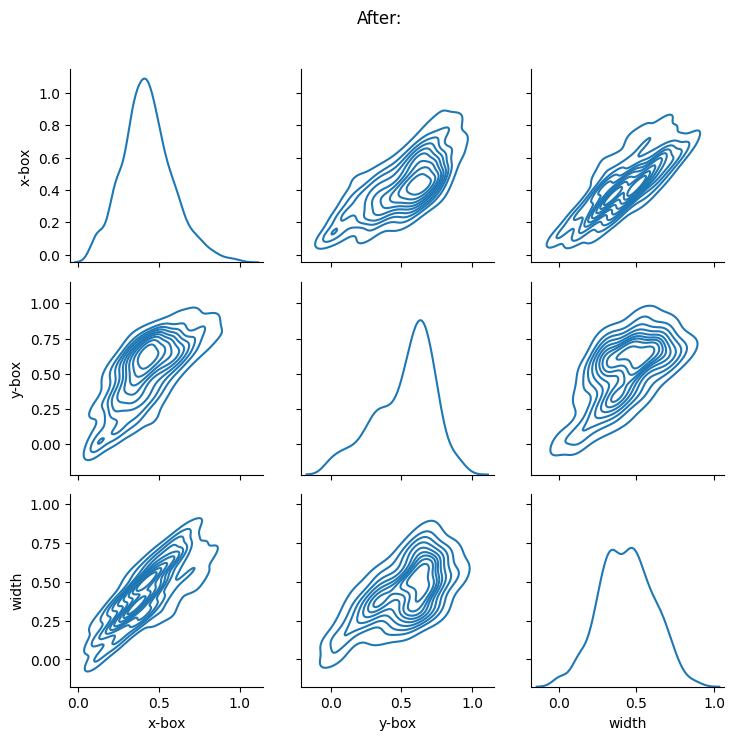

In [6]:
column_names = train_data.columns
g = sns.PairGrid(pd.DataFrame(x_train, columns=column_names).iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('After:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot)


In [7]:

# 定義計算重建誤差的函數
def calculate_reconstruction_loss(data, model):
    # 對每個樣本的每一個特徵給定一個異常分數
    reconstructions = model.predict(data)
    reconstruction_errors = np.mean(np.power(data - reconstructions, 2), axis=1) # mse
    return reconstruction_errors



# 定義超參數優化的目標函數
def objective(params):
    output_path = os.path.join(f"{params['epochs']}_epochs", 'autoencoder_best_weights.keras')
    
    # 重新構建模型
    model = tf.keras.models.Sequential()

    # 定義層數
    for _ in range(params['num_layers']):
        model.add(tf.keras.layers.Dense(int(params['units']), activation='relu'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
    
    model.add(tf.keras.layers.Dense(x_train.shape[1], activation='sigmoid'))  # 重建層

    # 編譯模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
                  loss=MeanSquaredError(),
                  metrics=["acc"])
    
    # model.summary()

    # define our early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',                         # 監控驗證損失 (其他:val_accuracy)
        min_delta=0.0001,                           # 最小變化量，若小於此值則視為無改進
        patience=10,                                # 允許 10 個 epoch 無改進後停止訓練
        verbose=1,                                  # 顯示早停過程的簡單信息  1：每次早停觸發時顯示信息
        mode='min',                                 # 監控指標是越小越好（對損失而言）
        restore_best_weights=True                   # 恢復最好的模型權重
    )


    save_model = tf.keras.callbacks.ModelCheckpoint(
        filepath=output_path,                       # 保存模型的文件路徑和名稱
        save_best_only=True,                        # 決定是否只保存最佳的模型
        monitor='val_loss',                         # 指定監控的指標  0：不顯示任何信息
        verbose=0,                                  # 設置回調的日誌顯示級別
        mode='min'                                  # 監控指標是越小越好（對損失而言）
    )

    # current date and time
    yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

    # new folder for a new run
    log_subdir = f"{yyyymmddHHMM}_batch{params['epochs']}_layers{len(model.layers)}"


    # 確保 logs 目錄存在
    log_dir = os.path.join('logs', log_subdir)
    tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir,                             # 存儲 TensorBoard 日誌的目錄
        update_freq='epoch'                          # 每處理一個 batch 時更新一次日誌 (epoch, batch...)
    )

    # callbacks argument only takes a list
    cb = [early_stop, save_model, tensorboard]

    # 訓練 Autoencoder 模型 - training
    history = model.fit(
        x_train, x_train,
        shuffle=True,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        callbacks=cb,
        validation_data=(x_valid, x_valid)
    )
    
    
    # 載入最佳模型權重並計算重建誤差
    model.load_weights(output_path)
    reconstruction_loss_normal = calculate_reconstruction_loss(x_valid, model)

    # 計算平均重建誤差
    val_loss = np.mean(reconstruction_loss_normal)
    
    # 保存當前最佳超參數和權重
    if val_loss < objective.best_loss:  # 只在損失改進時儲存最佳權重和參數
        objective.best_loss = val_loss
        objective.best_params = params
        model_dir = '../best_Autoencoder'
        os.makedirs(model_dir, exist_ok=True)
        model.save('../best_Autoencoder/best_model_weights.keras')  # 儲存最佳模型的權重
   
    
    return {'loss': val_loss, 'status': STATUS_OK, 'params': params}


# 初始化最佳損失值
objective.best_loss = float('inf')  # 設置初始的最佳損失值為無窮大


# 定義搜尋空間
space = {
    'num_layers': hp.choice('num_layers', [2, 3, 4, 5, 6]),  # 層數選擇
    'units': hp.quniform('units', 4, 256, 16),  # 每層的單元數
    'learning_rate': hp.loguniform('learning_rate', -9, -2),  # 學習率
    'epochs': hp.choice('epochs', [20, 50, 100, 200]),  # 訓練輪數
    'batch_size': hp.choice('batch_size', [16, 32, 64, 128])  # 批次大小
}


# # 定義搜尋空間 - 單測試1組
# space = {
#     'num_layers': hp.choice('num_layers', [4]),  # 層數選擇
#     'units': hp.quniform('units', 32, 256, 32),  # 每層的單元數
#     'learning_rate': hp.loguniform('learning_rate', -4, -2),  # 學習率
#     'epochs': hp.choice('epochs', [100]),  # 訓練輪數
#     'batch_size': hp.choice('batch_size', [32])  # 批次大小
# }


# 使用 Hyperopt 進行超參數搜尋
trials = Trials()
best = fmin(fn=objective, 
            space=space, 
            algo=tpe.suggest, 
            max_evals=10, 
            trials=trials, 
            verbose=0, 
            show_progressbar=True
        )

# 取得最佳結果
best_params = trials.best_trial['result']['params']
best_loss = trials.best_trial['result']['loss']

# 顯示最佳超參數
print("Best hyperparameters: ", best_params)
print(f"Best loss: {best_loss}")


c:\Users\s1092\Desktop\HW02\venv\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.1265 - loss: 0.2210 - val_acc: 0.1135 - val_loss: 0.2237
Epoch 2/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.1305 - loss: 0.2262 - val_acc: 0.1135 - val_loss: 0.2237
Epoch 3/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.1302 - loss: 0.2258 - val_acc: 0.1135 - val_loss: 0.2237
Epoch 4/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.1208 - loss: 0.2272 - val_acc: 0.1135 - val_loss: 0.2237
Epoch 5/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.1322 - loss: 0.2275 - val_acc: 0.1135 - val_loss: 0.2237
Epoch 6/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.1200 - loss: 0.2278 - val_acc: 0.1135 - val_loss: 0.2237
Epoch 7/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.1258 - loss: 0.2282 - val_acc: 0.1135 - val_loss: 0.2237
Epoch 8/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.1247 - loss: 0.2287 - val_acc: 0.1135 - val_loss: 0.2237
Epoch 9/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - ac

testing

In [ ]:
output_path="../best_Autoencoder"

y_test: [0 1 1 ... 1 1 1]
正常數量: 756
異常數量: 600
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


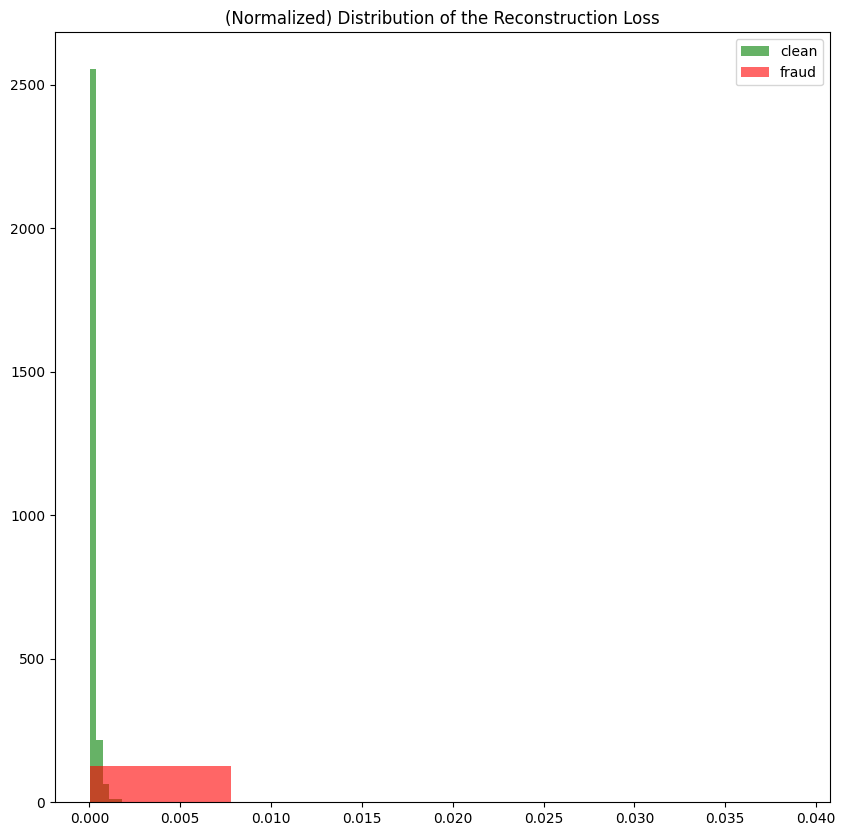

valid_data.csv
test_loss: 0.0008038837997729718


In [ ]:
# load test data
test_data = pd.read_csv(os.path.join(input_path, "valid_data.csv"))

# 目標字母列表
target_letters = ['B', 'E', 'K', 'N', 'X', 'Z']
lettr_test = test_data['lettr']
y_test = np.where(test_data['lettr'].isin(target_letters), 0, 1) # 正常 0 異常1

# 計算正常 (0) 和異常 (1) 的數量
normal_count = np.sum(y_test == 0)  # 正常數量 (0)
anomaly_count = np.sum(y_test == 1)  # 異常數量 (1)
print(f"y_test: {y_test}")

# 顯示結果
print(f"正常數量: {normal_count}")
print(f"異常數量: {anomaly_count}")

test_data = test_data.drop(columns=["lettr"])
x_test = pipeline.transform(test_data)

# 獲取最佳權重路徑
best_weight_path = os.path.join(output_path, 'best_model_weights.keras')

# 載入最佳權重
model = tf.keras.models.load_model(best_weight_path)


# 計算重建誤差
reconstruction_loss_normal = calculate_reconstruction_loss(x_test, model)

clean = reconstruction_loss_normal[y_test==0]
fraud = reconstruction_loss_normal[y_test==1]

fig, ax = plt.subplots(figsize=(10,10))

ax.hist(clean, bins=5, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=5, density=True, label="fraud", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

# 計算平均重建誤差
test_val_loss = np.mean(reconstruction_loss_normal)
print(f"valid_data.csv")
print(f"test_loss: {test_val_loss}")

# 儲存結果
results = pd.DataFrame({'id': test_data.index, 'outliers': reconstruction_loss_normal})
results.to_csv(os.path.join(output_path,"anomaly_detection_results.csv"), index=False)




In [ ]:
# load test data
test_data = pd.read_csv(os.path.join(input_path, "test_X.csv"))
x_test = pipeline.transform(test_data)


best_weight_path = '../best_Autoencoder/best_model_weights.keras'

# 載入最佳權重
model = tf.keras.models.load_model(best_weight_path)

# 計算重建誤差
reconstruction_loss_normal = calculate_reconstruction_loss(x_test, model)

# 計算平均重建誤差
test_loss = np.mean(reconstruction_loss_normal)
print(f"test_X.csv")
print(f"test_loss: {test_loss}")

# 儲存結果
results = pd.DataFrame({'id': test_data.index, 'outliers': reconstruction_loss_normal})
results.to_csv(os.path.join(output_path,"test_anomaly_detection_results.csv"), index=False)




32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
test_X.csv
test_loss: 0.0008841913282972724


In [10]:


# 顯示最佳超參數
print("Best hyperparameters: ", best_params)
print(f"Best loss: {best_loss}\n")

print(f"valid_data.csv")
print(f"test_loss: {test_val_loss}\n")

print(f"test_X.csv")
print(f"test_loss: {test_loss}\n")

# Best hyperparameters:  {'batch_size': 16, 'epochs': 400, 'learning_rate': 0.000733260453329279, 'num_layers': 3, 'units': 160.0}
# Best loss: 0.00015813230192507748

# valid_data.csv
# test_loss: 0.0007249107807058823

# test_X.csv
# test_loss: 0.0007358734093519275



Best hyperparameters:  {'batch_size': 32, 'epochs': 50, 'learning_rate': 0.0015512315843138232, 'num_layers': 3, 'units': 224.0}
Best loss: 0.00019436145567759415

valid_data.csv
test_loss: 0.0008038837997729718

test_X.csv
test_loss: 0.0008841913282972724

